In [1]:
import findspark
findspark.init()
findspark.find()

'C:\\Spark'

In [2]:
#Bibliotecas:
## Pyspark:
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql import types as t
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier,NaiveBayes,RandomForestClassifier
from pyspark.ml.feature import StringIndexer,OneHotEncoder,VectorAssembler,StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics

## Outras libs:
import os
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix


#Matriz de Confusao / Graficos
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from sklearn.metrics import confusion_matrix

In [3]:
# Configuração do Spark
conf = SparkConf().setAppName("BigdataTccLabhadooppyspark_c10_c").setMaster("local[*]").set("spark.executor.memory", "12g") \
                  .set("spark.driver.memory", "6g") \
                  .set("spark.executor.cores", "3").set("spark.executor.instances", "8") 
sc = SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [4]:
#Conexao com apache hadoop e carregamento do dadosarmazenados no HDFS 
hdfs_caminho = "hdfs://localhost:9000/user/belilo/ctu13/cenario10.csv"
df = spark.read.csv(hdfs_caminho, header=True, inferSchema=True)

In [5]:
df.show()

+----------+-----+------+---+------+--------+-----------+----+----+-------+--------+--------+
|     Label|Proto| Sport|Dir| Dport|   State|        Dur|sTos|dTos|TotPkts|TotBytes|SrcBytes|
+----------+-----+------+---+------+--------+-----------+----+----+-------+--------+--------+
|Background|  udp| 60621|<->| 63550|     CON| 2752.65625|   0|   0|      3|     435|     290|
|Background|  udp| 51413|<->| 63550|     CON|1849.315552|   0|   0|      3|     417|     272|
|Background|  udp| 63195|<->| 63550|     CON|2091.747314|   0|   0|      2|     290|     145|
|Background|  udp| 39110|<->| 63550|     CON|1535.769409|   0|   0|      2|     290|     145|
|Background|  tcp| 33426|<?>| 25443|FRPA_FPA|   0.002636|   0|   0|      6|     490|     321|
|Background|  udp| 41915|<->| 43087|     CON|   72.43679|   0|   0|  23849|24298138|  509912|
|Background|  tcp| 42020|<?>|   993|   PA_PA|3599.473633|   0|   0|    543|   98018|   33640|
|Background|  tcp| 49190|<?>|    80|   A_FPA|  28.152548|   

In [6]:
df.printSchema()

root
 |-- Label: string (nullable = true)
 |-- Proto: string (nullable = true)
 |-- Sport: string (nullable = true)
 |-- Dir: string (nullable = true)
 |-- Dport: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Dur: double (nullable = true)
 |-- sTos: integer (nullable = true)
 |-- dTos: integer (nullable = true)
 |-- TotPkts: integer (nullable = true)
 |-- TotBytes: integer (nullable = true)
 |-- SrcBytes: integer (nullable = true)



In [4]:
# PREPROCESSAMENTO
def renomear_atributos(df):
    df = df.withColumnRenamed('Proto','protocolo').withColumnRenamed('Sport','PortaOrigem').withColumnRenamed('Dir','Direcao')\
        .withColumnRenamed('Dport','PortaDestino').withColumnRenamed('State','Estado').withColumnRenamed('Dur','Duracao')\
        .withColumnRenamed('Label',"Rotulo")
    return df

def alterar_tipo_string_int(df):
    df = df.withColumn('PortaOrigem',f.col('Portaorigem').cast(t.IntegerType()))\
        .withColumn('PortaDestino',f.col('PortaDestino').cast(t.IntegerType()))
    return df

def verificaNullCol(df):
  for coluna in df.columns:
      print(coluna," : ", df.filter(df[coluna].isNull()).count())


def preencher_nulos_com_moda(df):
   # A impressao dos valores mostra o valor mais frequente (a moda) em cda uma das colunas que posuem dados nulos
  print("Nome da coluna : O valor com maior frequencia (Moda)")
  for coluna in df.columns:
      if df.filter(df[coluna].isNull()).count() != 0:
          count_mode_val = df.groupBy(coluna).count().filter(f.col(coluna).isNotNull())\
                              .agg(f.max("count")).collect()[0][0]
          mode_val = df.groupBy(coluna).count().filter(f.col(coluna).isNotNull())\
                              .filter(f.col("count") == count_mode_val).select(coluna).collect()[0][0]

          print(coluna," : ", mode_val)
          df=df.na.fill(mode_val,subset=[coluna])
  return df


#Funcao responsavel por verificar dados distentos em cada atrubuto
def mostrar_dados_distntos_atributos(df):
  df.createOrReplaceTempView("tabela")
  spark.sql("SELECT DISTINCT Duracao from tabela").show()
  spark.sql("SELECT DISTINCT protocolo from tabela").show()
  spark.sql("SELECT DISTINCT PortaOrigem from tabela").show()
  spark.sql("SELECT DISTINCT Direcao from tabela").show()
  spark.sql("SELECT DISTINCT PortaDestino from tabela").show()
  spark.sql("SELECT DISTINCT Estado from tabela").show()
  spark.sql("SELECT DISTINCT sTos from tabela").show()
  spark.sql("SELECT DISTINCT dTos from tabela").show()
  spark.sql("SELECT DISTINCT TotPkts from tabela").show()
  spark.sql("SELECT DISTINCT TotBytes from tabela").show()
  spark.sql("SELECT DISTINCT SrcBytes from tabela").show()
  spark.sql("SELECT DISTINCT Rotulo from tabela").show()

# Funcao responsavel por tratar ruido no atributo Direcao
def tratar_ruido(df):
  df.createOrReplaceTempView("tabela")
  df=spark.sql("SELECT Duracao, protocolo, PortaOrigem, REPLACE(Direcao, '?', '-') as Direcao, PortaDestino, Estado\
            ,sTos, dTos, TotPkts, TotBytes, SrcBytes, Rotulo  from tabela")
  return df

# Funcao usada para tornar o dataset com duas classes
def transformarClassBackgroud_normal(df):
    df.createOrReplaceTempView("tabela")
    df = spark.sql("SELECT Duracao, protocolo, PortaOrigem, Direcao, PortaDestino, Estado, \
                   sTos, dTos, TotPkts, TotBytes, SrcBytes, \
                   REPLACE(Rotulo, 'Background', 'Normal') as Rotulo  from tabela")
    return df

#Funcao Responsavel por eliinar linhas Repetidas / Duplicadas
def eliminarDuplicates(df):
 df=df.dropDuplicates()
 return df


In [8]:
df = renomear_atributos(df)
df.show(2)

df.printSchema()


+----------+---------+-----------+-------+------------+------+-----------+----+----+-------+--------+--------+
|    Rotulo|protocolo|PortaOrigem|Direcao|PortaDestino|Estado|    Duracao|sTos|dTos|TotPkts|TotBytes|SrcBytes|
+----------+---------+-----------+-------+------------+------+-----------+----+----+-------+--------+--------+
|Background|      udp|      60621|    <->|       63550|   CON| 2752.65625|   0|   0|      3|     435|     290|
|Background|      udp|      51413|    <->|       63550|   CON|1849.315552|   0|   0|      3|     417|     272|
+----------+---------+-----------+-------+------------+------+-----------+----+----+-------+--------+--------+
only showing top 2 rows

root
 |-- Rotulo: string (nullable = true)
 |-- protocolo: string (nullable = true)
 |-- PortaOrigem: string (nullable = true)
 |-- Direcao: string (nullable = true)
 |-- PortaDestino: string (nullable = true)
 |-- Estado: string (nullable = true)
 |-- Duracao: double (nullable = true)
 |-- sTos: integer (nu

In [9]:
df= alterar_tipo_string_int(df)
df.printSchema()

root
 |-- Rotulo: string (nullable = true)
 |-- protocolo: string (nullable = true)
 |-- PortaOrigem: integer (nullable = true)
 |-- Direcao: string (nullable = true)
 |-- PortaDestino: integer (nullable = true)
 |-- Estado: string (nullable = true)
 |-- Duracao: double (nullable = true)
 |-- sTos: integer (nullable = true)
 |-- dTos: integer (nullable = true)
 |-- TotPkts: integer (nullable = true)
 |-- TotBytes: integer (nullable = true)
 |-- SrcBytes: integer (nullable = true)



In [10]:
verificaNullCol(df)

Rotulo  :  0
protocolo  :  0
PortaOrigem  :  135176
Direcao  :  0
PortaDestino  :  135709
Estado  :  1228
Duracao  :  0
sTos  :  12852
dTos  :  186791
TotPkts  :  0
TotBytes  :  0
SrcBytes  :  0


In [11]:
df = preencher_nulos_com_moda(df)

Nome da coluna : O valor com maior frequencia (Moda)
PortaOrigem  :  13363
PortaDestino  :  53
Estado  :  CON
sTos  :  0
dTos  :  0


In [12]:
mostrar_dados_distntos_atributos(df)

+-----------+
|    Duracao|
+-----------+
|    7.18E-4|
|3017.522949|
| 3552.17749|
| 416.194489|
|     7.5E-4|
|  516.55481|
| 114.511345|
|    0.00195|
|   0.059421|
|3228.565918|
| 244.545197|
| 309.717377|
|    3.71E-4|
|    0.19075|
|   1.511531|
|   0.179585|
|   0.001894|
|  16.983456|
|3376.620605|
|3096.484131|
+-----------+
only showing top 20 rows

+---------+
|protocolo|
+---------+
|      arp|
|      esp|
|      tcp|
|     ipv6|
|  ipx/spx|
|      rtp|
|ipv6-icmp|
|      udt|
|      llc|
|     igmp|
|      pim|
|      udp|
|     icmp|
|     rtcp|
+---------+

+-----------+
|PortaOrigem|
+-----------+
|       1238|
|      53565|
|      53963|
|       4935|
|      35820|
|      43527|
|      13840|
|      37111|
|      63155|
|       6620|
|      44822|
|      29894|
|      53634|
|      49717|
|      20924|
|      50348|
|       2866|
|      57201|
|      23336|
|      35361|
+-----------+
only showing top 20 rows

+-------+
|Direcao|
+-------+
|    who|
|     ?>|
|    <->|

In [13]:
df =tratar_ruido(df)
df.select("Direcao").distinct().show()

+-------+
|Direcao|
+-------+
|    who|
|    <->|
|     <-|
|     ->|
+-------+



In [14]:
#Total de linhas antes da eliminacao de linhas duplicadas
df.count()

1309791

In [15]:
df = eliminarDuplicates(df)
df.count()

1189304

In [16]:
dfcont = df
dfcont.columns

['Duracao',
 'protocolo',
 'PortaOrigem',
 'Direcao',
 'PortaDestino',
 'Estado',
 'sTos',
 'dTos',
 'TotPkts',
 'TotBytes',
 'SrcBytes',
 'Rotulo']

In [17]:
# Salva dados como ponto de restuaro   em formato CSV no HDFS
caminhohdfs = "hdfs://localhost:9000/user/belilo/ctu13/preprocessamentofase2/preprocesfase2c10.csv"
dfcont.write.csv(caminhohdfs, header=True, mode="overwrite")

In [6]:
#Carregar os dados do hdfs
caminhohdfs = "hdfs://localhost:9000/user/belilo/ctu13/preprocessamentofase2/preprocesfase2c10.csv"
dfcont = spark.read.csv(caminhohdfs, header=True, inferSchema=True)

In [8]:
dfcont = transformarClassBackgroud_normal(dfcont)
dfcont.show(3)

+----------+---------+-----------+-------+------------+---------+----+----+-------+--------+--------+------+
|   Duracao|protocolo|PortaOrigem|Direcao|PortaDestino|   Estado|sTos|dTos|TotPkts|TotBytes|SrcBytes|Rotulo|
+----------+---------+-----------+-------+------------+---------+----+----+-------+--------+--------+------+
|633.004517|      tcp|      49615|    <->|       31002|  FPA_FPA|   0|   0|   1231|  107062|   36468|Normal|
| 18.405928|      tcp|      49980|     ->|          80|FSPA_FSPA|   0|   0|     11|    1838|     793|Normal|
|   2.17E-4|      udp|      58255|    <->|          53|      CON|   0|   0|      2|     214|      81|Normal|
+----------+---------+-----------+-------+------------+---------+----+----+-------+--------+--------+------+
only showing top 3 rows



In [9]:
dfcont.select("Rotulo").distinct().show()

+------+
|Rotulo|
+------+
|Botnet|
|Normal|
+------+



In [10]:
contagem_por_rotulo = dfcont.groupBy("Rotulo").count()

In [11]:
contagem_por_rotulo.show()

+------+-------+
|Rotulo|  count|
+------+-------+
|Botnet|  10153|
|Normal|1179151|
+------+-------+



In [21]:
dfcont.select("Rotulo").distinct().count()

2

In [22]:
dfcont.count()

1189304

## Balacenamento de dados de treino

In [23]:
#!pip install --upgrade scikit-learn imbalanced-learn

In [24]:
from imblearn.over_sampling import ADASYN
from collections import Counter

In [25]:
from imblearn.under_sampling import NearMiss
from pandas.plotting import autocorrelation_plot

In [26]:
df_treinarDesiquilibrado = dfcont

In [27]:
df_treinarDesiquilibrado.count()

1189304

In [32]:
df_treinarDesiquilibrado = df_treinarDesiquilibrado.toPandas()

In [33]:
df_treinarDesiquilibradoc10 = df_treinarDesiquilibrado
df_treinarDesiquilibradoc10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1189304 entries, 0 to 1189303
Data columns (total 12 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Duracao       1189304 non-null  float64
 1   protocolo     1189304 non-null  object 
 2   PortaOrigem   1189304 non-null  int32  
 3   Direcao       1189304 non-null  object 
 4   PortaDestino  1189304 non-null  int32  
 5   Estado        1189304 non-null  object 
 6   sTos          1189304 non-null  int32  
 7   dTos          1189304 non-null  int32  
 8   TotPkts       1189304 non-null  int32  
 9   TotBytes      1189304 non-null  int32  
 10  SrcBytes      1189304 non-null  int32  
 11  Rotulo        1189304 non-null  object 
dtypes: float64(1), int32(7), object(4)
memory usage: 77.1+ MB


In [34]:
df_treinarDesiquilibradoc10.isnull().sum()  

Duracao         0
protocolo       0
PortaOrigem     0
Direcao         0
PortaDestino    0
Estado          0
sTos            0
dTos            0
TotPkts         0
TotBytes        0
SrcBytes        0
Rotulo          0
dtype: int64

In [35]:
df_treinarDesiquilibradoc10.head()

,Duracao,protocolo,PortaOrigem,Direcao,PortaDestino,Estado,sTos,dTos,TotPkts,TotBytes,SrcBytes,Rotulo
0,633.004517,tcp,49615,<->,31002,FPA_FPA,0,0,1231,107062,36468,Normal
1,18.405928,tcp,49980,->,80,FSPA_FSPA,0,0,11,1838,793,Normal
2,0.000217,udp,58255,<->,53,CON,0,0,2,214,81,Normal
3,0.178527,tcp,49803,<->,443,FA_FA,0,0,3,180,120,Normal
4,3092.976807,udp,13363,<->,5318,CON,0,0,4,274,154,Normal


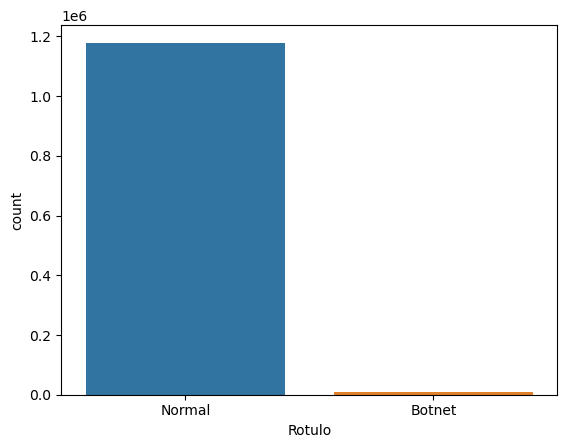

In [38]:
df_treinarDesiquilibradoc10.Rotulo.value_counts()
ax = sns.countplot(x="Rotulo", data =  df_treinarDesiquilibradoc10)

In [39]:
#Formatar colunas categoricas em numericas
def gerar_mapa_atrubutos_categoricos(data, coluna_to_map):
    dicionario_map = {}

    for coluna in coluna_to_map:
        unique_values = data[coluna].unique()
        mapear = {value: index + 1 for index, value in enumerate(unique_values)}
        dicionario_map[coluna] = mapear

    return dicionario_map

def formatar_colunas_categoricas(data, coluna_map):
    formatar_data = data.copy()

    for coluna, mapear in coluna_map.items():
        formatar_data[coluna] = formatar_data[coluna].map(mapear)

    return formatar_data

def restaurar_atributos_categoricos(dados_formatado, dicionario_map):
    dados_restaurados = dados_formatado.copy()

    for coluna, mapear in dicionario_map.items():
        reverso_map = {v: k for k, v in mapear.items()}
        dados_restaurados[coluna] = dados_restaurados[coluna].map(reverso_map)

    return dados_restaurados

In [40]:
variavescategoricas = ['protocolo', 'Direcao', 'Estado', 'Rotulo']
# Gerar o dicionário de mapeamento
dicionario_mapa = gerar_mapa_atrubutos_categoricos(df_treinarDesiquilibradoc10, variavescategoricas)

In [41]:
dados_formatados = formatar_colunas_categoricas(df_treinarDesiquilibradoc10, dicionario_mapa)

In [42]:
dados_formatados.head()

,Duracao,protocolo,PortaOrigem,Direcao,PortaDestino,Estado,sTos,dTos,TotPkts,TotBytes,SrcBytes,Rotulo
0,633.004517,1,49615,1,31002,1,0,0,1231,107062,36468,1
1,18.405928,1,49980,2,80,2,0,0,11,1838,793,1
2,0.000217,2,58255,1,53,3,0,0,2,214,81,1
3,0.178527,1,49803,1,443,4,0,0,3,180,120,1
4,3092.976807,2,13363,1,5318,3,0,0,4,274,154,1


In [43]:
valores_distintos = dados_formatados['Rotulo'].unique()
print(valores_distintos)

[1 2]


<Axes: ylabel='Rotulo'>

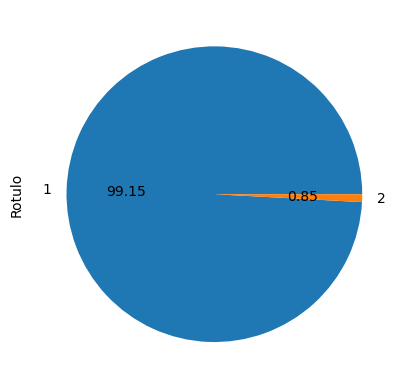

In [44]:
#Separar os dados e suas classes
x =  dados_formatados.drop("Rotulo",axis = 1)
y =  dados_formatados.Rotulo

y.value_counts().plot.pie(autopct='%.2f')

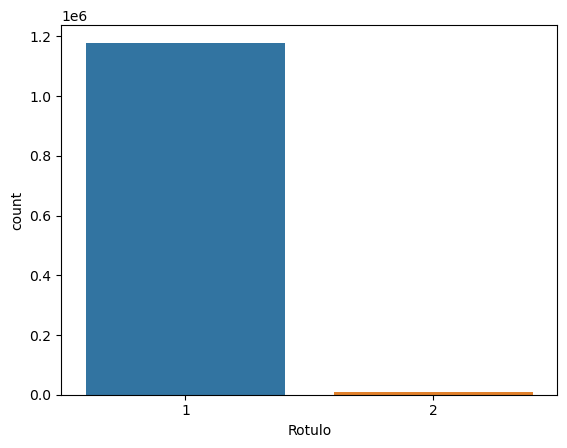

In [45]:
ax = sns.countplot(x=y)

In [46]:
#!pip install -U imbalanced-learn

In [47]:
# Aplicando ADASYN Com Geracao de dados sinteticos a 60% da classe maioritaria
print("Contagem das classes Antes do adasyn:", Counter(y))
adasyn = ADASYN(sampling_strategy=0.6, n_neighbors=5)
x_resample,y_resample = adasyn.fit_resample(x,y)
print("Contagem das classes Depois do adasyn:", Counter(y_resample))

Contagem das classes Antes do adasyn: Counter({1: 1179151, 2: 10153})
Contagem das classes Depois do adasyn: Counter({1: 1179151, 2: 707503})


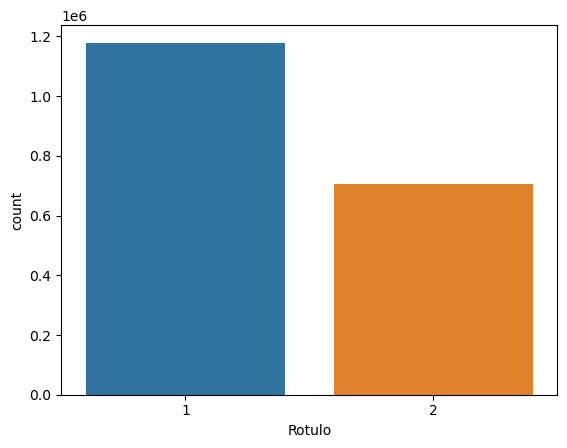

In [48]:
ax = sns.countplot(x=y_resample)

In [49]:
#Aplicar a tecnica de NearMiss
near_miss = NearMiss()
x_resample1, y_resample1 = near_miss.fit_resample(x_resample,y_resample)

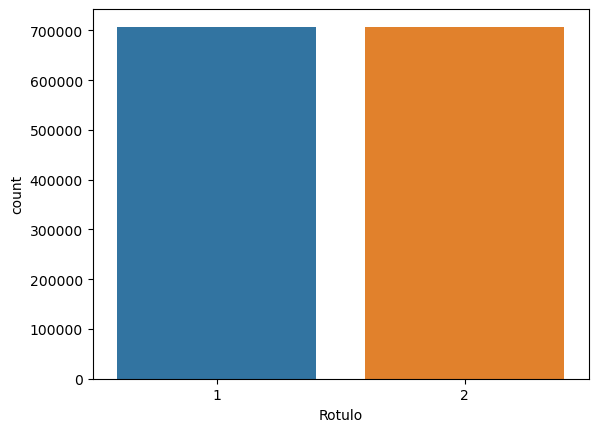

In [50]:
ax = sns.countplot(x=y_resample1)

In [51]:
print("Contagem das classes Depois do Near_Miss:", Counter(y_resample1))

Contagem das classes Depois do Near_Miss: Counter({1: 1126133, 2: 1126133})


In [51]:
dados_c10_equilibrados = x_resample1
dados_c10_equilibrados["Rotulo"] =y_resample1
dados_c10_equilibrados.head()

,Duracao,protocolo,PortaOrigem,Direcao,PortaDestino,Estado,sTos,dTos,TotPkts,TotBytes,SrcBytes,Rotulo
0,0.0,3,13363,2,53,20,0,0,1,536,536,1
1,0.0,3,13363,2,53,20,0,0,1,304,304,1
2,0.0,3,13363,2,53,20,0,0,1,357,357,1
3,0.0,3,13363,2,53,20,0,0,1,419,419,1
4,0.0,3,13363,2,53,20,0,0,1,225,225,1


In [52]:
dados_c10_equilibrados.count()

Duracao         1415006
protocolo       1415006
PortaOrigem     1415006
Direcao         1415006
PortaDestino    1415006
Estado          1415006
sTos            1415006
dTos            1415006
TotPkts         1415006
TotBytes        1415006
SrcBytes        1415006
Rotulo          1415006
dtype: int64

In [53]:
# Restaure as colunas categóricas para obter o DataFrame original
dados_c10_equil_restaurado = restaurar_atributos_categoricos(dados_c10_equilibrados, dicionario_mapa)

In [54]:
dados_c10_equil_restaurado.isnull().sum()

Duracao         0
protocolo       0
PortaOrigem     0
Direcao         0
PortaDestino    0
Estado          0
sTos            0
dTos            0
TotPkts         0
TotBytes        0
SrcBytes        0
Rotulo          0
dtype: int64

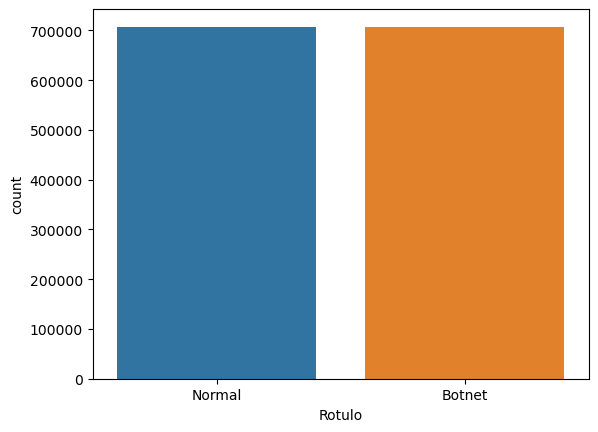

In [55]:
ax = sns.countplot(x="Rotulo", data =  dados_c10_equil_restaurado)

In [56]:
dados_c10_equil_restaurado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1415006 entries, 0 to 1415005
Data columns (total 12 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Duracao       1415006 non-null  float64
 1   protocolo     1415006 non-null  object 
 2   PortaOrigem   1415006 non-null  int32  
 3   Direcao       1415006 non-null  object 
 4   PortaDestino  1415006 non-null  int32  
 5   Estado        1415006 non-null  object 
 6   sTos          1415006 non-null  int32  
 7   dTos          1415006 non-null  int32  
 8   TotPkts       1415006 non-null  int32  
 9   TotBytes      1415006 non-null  int32  
 10  SrcBytes      1415006 non-null  int32  
 11  Rotulo        1415006 non-null  object 
dtypes: float64(1), int32(7), object(4)
memory usage: 91.8+ MB


In [62]:
pip install hdfs

Note: you may need to restart the kernel to use updated packages.


In [63]:
from hdfs import InsecureClient
hdfs_client = InsecureClient('http://localhost:9870', user='Belilo')

In [64]:
dados_c10_equil_restaurado.to_csv('dados_treino_c10_equilibrado.csv', index=False)

In [65]:
dados_c10_equil_restaurado.head()

,Duracao,protocolo,PortaOrigem,Direcao,PortaDestino,Estado,sTos,dTos,TotPkts,TotBytes,SrcBytes,Rotulo
0,0.0,icmp,13363,->,53,URP,0,0,1,536,536,Normal
1,0.0,icmp,13363,->,53,URP,0,0,1,304,304,Normal
2,0.0,icmp,13363,->,53,URP,0,0,1,357,357,Normal
3,0.0,icmp,13363,->,53,URP,0,0,1,419,419,Normal
4,0.0,icmp,13363,->,53,URP,0,0,1,225,225,Normal


In [67]:
hdfs_destino = '/user/belilo/ctu13/preprocessamentofase2'
hdfs_client.upload(hdfs_destino, 'dados_treino_c10_equilibrado.csv')

'/user/belilo/ctu13/preprocessamentofase2/dados_treino_c10_equilibrado.csv'


### Aplicacao de transformacao  nos dados para Treinamento e teste

In [5]:
#dados de treino armazenado no hdfs
caminhohdfs = 'hdfs://localhost:9000/user/belilo/ctu13/preprocessamentofase2/dados_treino_c10_equilibrado.csv'
dados_c10_equilibrado = spark.read.csv(caminhohdfs, header=True, inferSchema=True)

In [6]:
verificaNullCol(dados_c10_equilibrado)

Duracao  :  0
protocolo  :  0
PortaOrigem  :  0
Direcao  :  0
PortaDestino  :  0
Estado  :  0
sTos  :  0
dTos  :  0
TotPkts  :  0
TotBytes  :  0
SrcBytes  :  0
Rotulo  :  0


In [7]:
dados_c10_equilibrado.show(3)

+-------+---------+-----------+-------+------------+------+----+----+-------+--------+--------+------+
|Duracao|protocolo|PortaOrigem|Direcao|PortaDestino|Estado|sTos|dTos|TotPkts|TotBytes|SrcBytes|Rotulo|
+-------+---------+-----------+-------+------------+------+----+----+-------+--------+--------+------+
|    0.0|     icmp|      13363|     ->|          53|   URP|   0|   0|      1|     536|     536|Normal|
|    0.0|     icmp|      13363|     ->|          53|   URP|   0|   0|      1|     304|     304|Normal|
|    0.0|     icmp|      13363|     ->|          53|   URP|   0|   0|      1|     357|     357|Normal|
+-------+---------+-----------+-------+------------+------+----+----+-------+--------+--------+------+
only showing top 3 rows



In [6]:
def stringIndex(df):
  variavesCategoricas =['protocolo','Direcao','Estado','Rotulo']
  stages = []
  for column in variavesCategoricas:
      indexer = StringIndexer(inputCol=column, outputCol=column+"_index")
      stages += [indexer]
  input_columns = ['Duracao','protocolo_index','PortaOrigem','Direcao_index', 'PortaDestino','Estado_index'\
                   ,'sTos','dTos', 'TotPkts', 'TotBytes','SrcBytes']

  assembler = VectorAssembler(inputCols=input_columns, outputCol="features")
  stages += [assembler]
  pipeline = Pipeline(stages=stages)

  transformed_df = pipeline.fit(df).transform(df)
  dado = transformed_df
  return dado

def padronizacao_de_dados(df):
    df_padrizacao = df.select(f.col('features'),f.col('Rotulo_index')).withColumnRenamed("Rotulo_index",'label')
    standerscaler = StandardScaler().setInputCol('features').setOutputCol('scaled_features')
    df_padronizado = standerscaler.fit(df_padrizacao).transform(df_padrizacao)
    return df_padronizado

In [7]:
dfc10 = stringIndex(dados_c10_equilibrado)

In [8]:
dfc10.show(3)

+-------+---------+-----------+-------+------------+------+----+----+-------+--------+--------+------+---------------+-------------+------------+------------+--------------------+
|Duracao|protocolo|PortaOrigem|Direcao|PortaDestino|Estado|sTos|dTos|TotPkts|TotBytes|SrcBytes|Rotulo|protocolo_index|Direcao_index|Estado_index|Rotulo_index|            features|
+-------+---------+-----------+-------+------------+------+----+----+-------+--------+--------+------+---------------+-------------+------------+------------+--------------------+
|    0.0|     icmp|      13363|     ->|          53|   URP|   0|   0|      1|     536|     536|Normal|            1.0|          0.0|         5.0|         1.0|[0.0,1.0,13363.0,...|
|    0.0|     icmp|      13363|     ->|          53|   URP|   0|   0|      1|     304|     304|Normal|            1.0|          0.0|         5.0|         1.0|[0.0,1.0,13363.0,...|
|    0.0|     icmp|      13363|     ->|          53|   URP|   0|   0|      1|     357|     357|Norma

In [9]:
dfc10_padronizado = padronizacao_de_dados(dfc10)

In [10]:
dfc10_padronizado.show(3)

+--------------------+-----+--------------------+
|            features|label|     scaled_features|
+--------------------+-----+--------------------+
|[0.0,1.0,13363.0,...|  1.0|[0.0,1.2762908869...|
|[0.0,1.0,13363.0,...|  1.0|[0.0,1.2762908869...|
|[0.0,1.0,13363.0,...|  1.0|[0.0,1.2762908869...|
+--------------------+-----+--------------------+
only showing top 3 rows



### Treinamento dos modelos

In [11]:
 # Divisão dos dados treinamento, validação e teste
df_treinamentoc10, df_testec10 = dfc10_padronizado.randomSplit([0.7, 0.3], seed=123)

In [14]:
def grafico_percentagem_porporcao_dados_por_classes(df,tilulo_grafico):
    df_pandas = df.select("label").toPandas()
    contagem_classes = df_pandas["label"].value_counts()
    porcentagens = contagem_classes / contagem_classes.sum() * 100
    ax = porcentagens.plot(kind="bar")
    plt.title(tilulo_grafico)
    plt.xlabel("Classe")
    plt.ylabel("Contagem")
    plt.xticks(rotation=0)  
    for i, v in enumerate(porcentagens):
        ax.text(i, v + 1, f"{v:.2f}%", ha="center")
    plt.show()

In [15]:
df_treinamentoc10.count()

990052

In [16]:
df_testec10.count()

424954

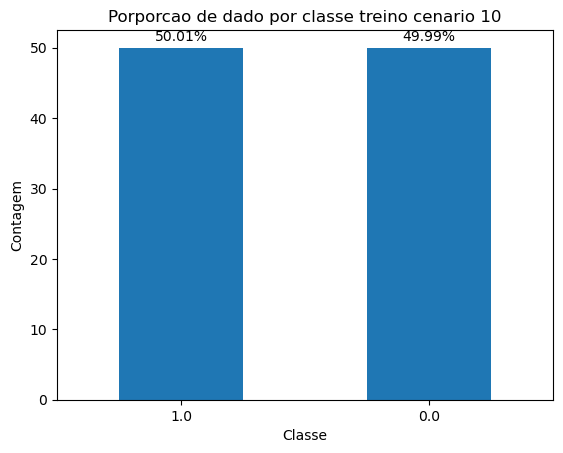

In [23]:
grafico_percentagem_porporcao_dados_por_classes(df_treinamentoc10,"Porporcao de dado por classe treino cenario 10")

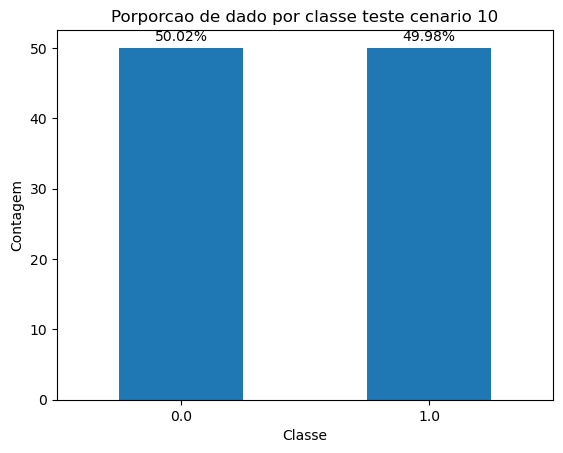

In [24]:
grafico_percentagem_porporcao_dados_por_classes(df_testec10,"Porporcao de dado por classe teste cenario 10")

In [14]:
def perform_cross_validation_models(data, estimator, param_grid, num_folds, metric_name):
    evaluator = MulticlassClassificationEvaluator(metricName=metric_name)
    pipeline = Pipeline(stages=[estimator])
    crossval = CrossValidator(estimator=pipeline\
                              ,estimatorParamMaps=param_grid\
                              ,evaluator=evaluator\
                              ,numFolds=num_folds\
                              ,seed=42)
    cv_model = crossval.fit(data)
    return cv_model

In [14]:
from pyspark.ml.classification import GBTClassifier
#CRIAR MODELOS
nb = NaiveBayes(featuresCol="scaled_features", labelCol="label")
dt = DecisionTreeClassifier(labelCol="label", featuresCol="scaled_features")
rfc = RandomForestClassifier(labelCol='label', featuresCol='scaled_features')

In [15]:

from pyspark.ml.tuning import ParamGridBuilder

# Definindo os parâmetros para o grid
paramGrid_nb = (ParamGridBuilder()
                .addGrid(nb.smoothing, [0.1, 0.3, 0.5, 0.7, 0.9, 1])
                .addGrid(nb.modelType, ['multinomial'])
                .addGrid(nb.thresholds, [[0.5, 0.5], [0.6, 0.4], [0.4, 0.6]])
                .build())

paramGrid_dt = (ParamGridBuilder()
                .addGrid(dt.maxDepth, [5, 10, 15, 20, 25, 28])
                .addGrid(dt.maxBins, [16, 32, 64, 128, 256])
                .build())

paramGrid_rfc = (ParamGridBuilder()
                 .addGrid(rfc.maxDepth, [5, 10, 18, 25, 28])
                 .addGrid(rfc.maxBins, [16, 32, 64, 128, 256])
                 .build())


In [15]:
# funcoes de processamento

def predicao_modelo(modelo,df_teste):
  predicao = modelo.transform(df_teste)
  predicao = predicao.select("label", "prediction")
  return predicao

def acuracia (df):
    predicaorotulo=df.select('label','prediction')
    Evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
    acuracia_model = Evaluator.evaluate(predicaorotulo)
    print("Acuracia: ", (acuracia_model * 100))
    
def precisao(df):
    predicaorotulo =df.select('label','prediction')
    Evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='precisionByLabel')
    precisao_model = Evaluator.evaluate(predicaorotulo)

    print("Precisao: ", (precisao_model * 100))
    
def revocacao_recall(df):
    predicaorotulo = df.select('label','prediction')
    Evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='recallByLabel')
    recal_model = Evaluator.evaluate(predicaorotulo)
    print("Recall: ", (recal_model * 100))
    
def f1_Score(df):
    predicaorotulo = df.select('label','prediction')
    Evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
    f1_model = Evaluator.evaluate(predicaorotulo)
    print("f1_score: ", (f1_model * 100))


In [16]:
def auc(predictions):
    evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC")
    area_ROC = evaluator.evaluate(predictions)
    print("AUC: ", (area_ROC * 100))

In [17]:
# Funcao Matriz de confusao
def matriz_de_confusao(predicao):
    y_true = predicao.select("label").toPandas()
    y_pred = predicao.select("prediction").toPandas()
    Matriz_confusao = confusion_matrix(y_true, y_pred)
    return Matriz_confusao

# Visualizar Matriz de confusao
def visualizar_matriz(matriz,tilulo):
    classes = ['Botnet', 'Normal']
    grafico = sns.heatmap(matriz, annot=True, cmap='Blues', fmt='d', xticklabels=classes\
                          , yticklabels=classes)
    plt.figure(figsize=(8, 6))
    grafico.set_title(tilulo)
    plt.xlabel('Classe Predita')
    plt.ylabel('Classe Real')
    plt.show()
    
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def matriz_de_confusao_percentagem(predicao):
    y_true = predicao.select("label").toPandas()
    y_pred = predicao.select("prediction").toPandas()
    Matriz_confusao = confusion_matrix(y_true, y_pred)    
    total_por_classe = Matriz_confusao.sum(axis=1)
    matriz_percentagem = (Matriz_confusao.T / total_por_classe).T
    return matriz_percentagem

# Visualizar Matriz de confusao em porcentagem
def visualizar_matriz_percentagem(matriz, titulo):
    classes = ['Botnet', 'Normal']
    grafico = sns.heatmap(matriz, annot=True, cmap='Blues', fmt='.2%', xticklabels=classes, yticklabels=classes)
    grafico.set_title(titulo)
    plt.xlabel('Classe Predita')
    plt.ylabel('Classe Real')
    plt.show()

In [16]:
import pandas as pd
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import functions as F

def custom_cross_validation(data, model, param_grid, num_folds):
    evaluator = MulticlassClassificationEvaluator()
    metrics = []
    
    data_with_fold = data.withColumn('fold', (F.rand() * num_folds).cast('int'))
    
    crossval = CrossValidator(estimator=model,
                              estimatorParamMaps=param_grid,
                              evaluator=evaluator,
                              numFolds=num_folds,
                              seed=42)
    
    cv_model = crossval.fit(data_with_fold)
    
    best_models = cv_model.bestModel
    
    for fold in range(num_folds):
        train = data_with_fold.filter(data_with_fold['fold'] != fold)
        test = data_with_fold.filter(data_with_fold['fold'] == fold)
        
        predictions = best_models.transform(test)
        
        accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
        precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
        recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
        f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
        
        metrics.append({'Fold': fold + 1,
                        'Acuracia': accuracy,
                        'Precisao': precision,
                        'Recall': recall,
                        'F1-score': f1_score})
    
    mean_metrics = {'Fold': 'Total media'}
    for metric_name in ['Acuracia', 'Precisao', 'Recall', 'F1-score']:
        mean_metrics[metric_name] = sum(metric[metric_name] for metric in metrics) / num_folds
    
    metrics.append(mean_metrics)
    
    df_metrics = pd.DataFrame(metrics)
    
    return df_metrics

In [17]:
resultados = custom_cross_validation(df_treinamentoc10, nb, paramGrid_nb, 5)

In [18]:
print ("MELHORES DESEMPENHO EM CADA FOLD PARA TODAS METRICAS NB")
print(resultados)

MELHORES DESEMPENHO EM CADA FOLD PARA TODAS METRICAS NB
          Fold  Acuracia  Precisao    Recall  F1-score
0            1  0.839108  0.840434  0.839108  0.838950
1            2  0.839374  0.840800  0.839374  0.839190
2            3  0.840367  0.841762  0.840367  0.840199
3            4  0.839885  0.841203  0.839885  0.839717
4            5  0.839726  0.841384  0.839726  0.839564
5  Total media  0.839692  0.841117  0.839692  0.839524


In [19]:
resultados_dt = custom_cross_validation(df_treinamentoc10, dt, paramGrid_dt, 5)

In [20]:
print("MELHORES DESEMPENHO EM CADA FOLD PARA TODAS METRICAS DT")
print(resultados_dt)

MELHORES DESEMPENHO EM CADA FOLD PARA TODAS METRICAS DT
          Fold  Acuracia  Precisao    Recall  F1-score
0            1  0.999950  0.999950  0.999950  0.999950
1            2  0.999934  0.999934  0.999934  0.999934
2            3  0.999949  0.999949  0.999949  0.999949
3            4  0.999934  0.999934  0.999934  0.999934
4            5  0.999934  0.999934  0.999934  0.999934
5  Total media  0.999940  0.999940  0.999940  0.999940


In [21]:
resultados_rfc = custom_cross_validation(df_treinamentoc10, rfc, paramGrid_rfc, 5)

In [22]:
print("MELHORES DESEMPENHO EM CADA FOLD PARA TODAS METRICAS  RFC")
print(resultados_rfc)

MELHORES DESEMPENHO EM CADA FOLD PARA TODAS METRICAS  RFC
          Fold  Acuracia  Precisao    Recall  F1-score
0            1  0.999914  0.999914  0.999914  0.999914
1            2  0.999930  0.999930  0.999930  0.999930
2            3  0.999929  0.999929  0.999929  0.999929
3            4  0.999934  0.999934  0.999934  0.999934
4            5  0.999975  0.999975  0.999975  0.999975
5  Total media  0.999936  0.999936  0.999936  0.999936


In [18]:
cv_model_nb_models = perform_cross_validation_models(df_treinamentoc10,nb, paramGrid_nb, 5,"f1")

In [22]:
cv_model_dt = perform_cross_validation_models(df_treinamentoc10,dt, paramGrid_dt, 5,"f1")

In [33]:
cv_model_rfc = perform_cross_validation_models(df_treinamentoc10,rfc, paramGrid_rfc, 5,"f1")

 ## Graficos

### Graficos de curva de aprendizado

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


def plot_learning_curve(cv_model, metric_name,model_name):
    train_metrics = cv_model.avgMetrics
    val_metrics = cv_model.avgMetrics
    plt.plot(train_metrics, label='Treinamento {}'.format(metric_name))
    plt.plot(val_metrics, label='Validação {}'.format(metric_name))
    plt.xlabel('Número de Iteraçõess')
    plt.ylabel(metric_name)
    plt.title('Curva de Aprendizado para {} em cada Fold - {}'.format(metric_name, model_name))
    #plt.xticks(range(len(train_metrics)), range(len(train_metrics)))
    plt.legend()
    plt.show()

def get_metrics(cv_model, metric_name):
    avg_metrics = cv_model.avgMetrics
    best_index = np.argmax(avg_metrics)
    best_metric = avg_metrics[best_index]
    print("Best {} achieved: {:.4f}".format(metric_name, best_metric))
    return best_metric

def evaluate_model(cv_model, metric_name):
    evaluator = MulticlassClassificationEvaluator(metricName=metric_name)
    train_metric = evaluator.evaluate(cv_model.transform(df_treinamentoc10))
    test_metric = evaluator.evaluate(cv_model.transform(df_testec10))
    print("Training {} for best model: {:.4f}".format(metric_name, train_metric))
    print("Test {} for best model: {:.4f}".format(metric_name, test_metric))



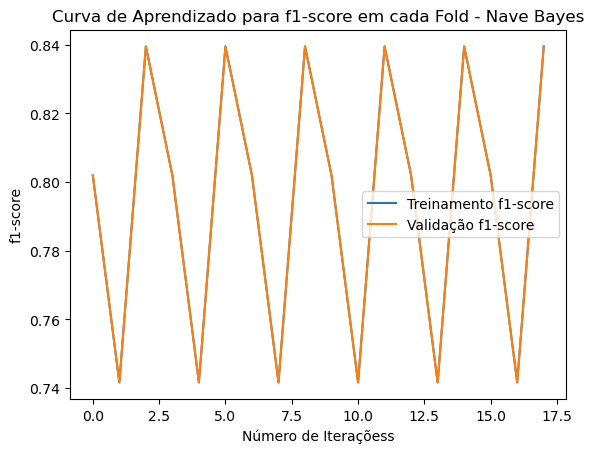

In [28]:

plot_learning_curve(cv_model_nb_models, "f1-score","Nave Bayes")


In [24]:
best_f1_nb = get_metrics(cv_model_nb_models, "f1-score")


Best f1-score achieved: 0.8395


In [27]:
evaluate_model(cv_model_nb_models, "f1")


Training f1 for best model: 0.8395
Test f1 for best model: 0.8400


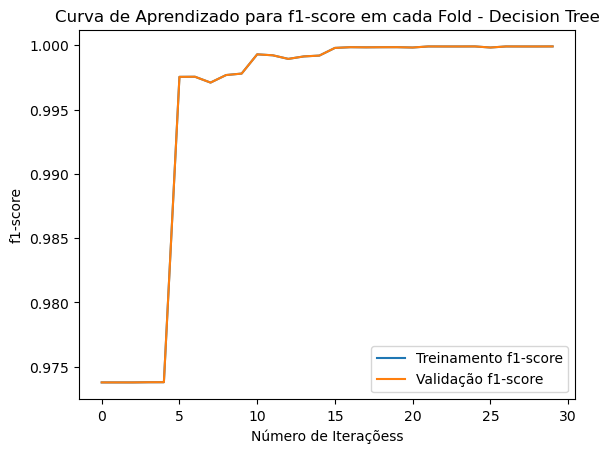

In [29]:
plot_learning_curve(cv_model_dt, "f1-score","Decision Tree")

In [30]:
best_f1_nb = get_metrics(cv_model_dt, "f1-score")

Best f1-score achieved: 0.9999


In [31]:
evaluate_model(cv_model_dt, "f1")

Training f1 for best model: 0.9999
Test f1 for best model: 0.9999


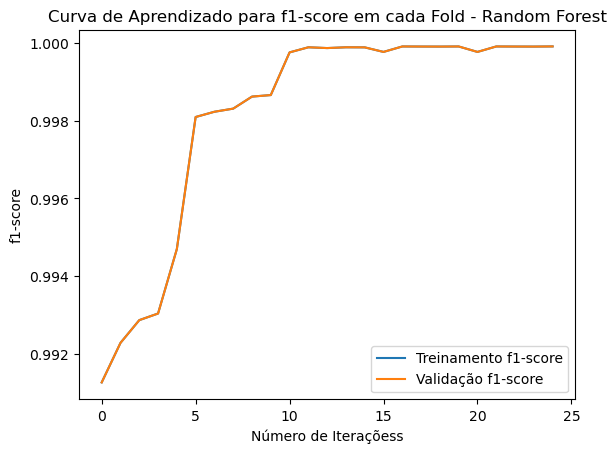

In [35]:
plot_learning_curve(cv_model_rfc, "f1-score", "Random Forest")

In [36]:
best_f1_nb = get_metrics(cv_model_rfc, "f1-score")

Best f1-score achieved: 0.9999


In [37]:
evaluate_model(cv_model_rfc, "f1")

Training f1 for best model: 0.9999
Test f1 for best model: 0.9999


### Grafico de curva ROC

In [26]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curves1(models, test_data):
    plt.figure(figsize=(8, 6))
    for model_name, model in models.items():
        predictions = model.transform(test_data)
        probabilities = predictions.select('label', 'probability').toPandas()
        fpr, tpr, _ = roc_curve(probabilities['label'], probabilities['probability'].apply(lambda x: x[1]))
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='%s (AUC = %0.2f)' % (model_name, roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
    plt.title('Curvas ROC para Modelos')
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.legend()
    plt.show()


In [27]:
# Crie um dicionário com os modelos treinados
models = {
    'Naive Bayes': cv_model_nb_models.bestModel,
    'Decision Tree': cv_model_dt.bestModel,
    'Random Forest': cv_model_rfc.bestModel,
}

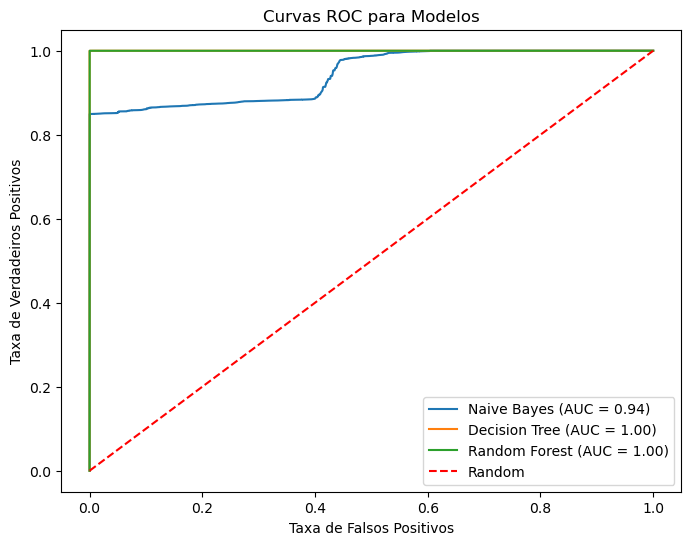

In [28]:
# Chame a função para plotar as curvas ROC
plot_roc_curves1(models, df_testec10)

# Avaliacao dos modelos (Predicao

In [29]:
def melhor_modelo (cv_model):
  best_model = cv_model.bestModel
  return best_model

In [30]:
melhor_model_nb = melhor_modelo (cv_model_nb_models)
melhor_model_dt = melhor_modelo (cv_model_dt)
melhor_model_rfc = melhor_modelo (cv_model_rfc)

In [54]:
from sklearn.metrics import classification_report
import pandas as pd
def reporte_classificacao(bestModel,df_teste):
    predictions = cv_model_nb_models.transform(df_teste)
    predictions_pd = predictions.select("label", "prediction").toPandas()
    y_true = predictions_pd["label"].tolist()
    y_pred = predictions_pd["prediction"].tolist()
    reporte = classification_report(y_true, y_pred)
    return reporte


In [55]:

reporte_classf_nb = reporte_classificacao(melhor_model_nb,df_testec10)
reporte_classf_dt = reporte_classificacao(melhor_model_dt,df_testec10)
reporte_classf_rfc = reporte_classificacao(melhor_model_rfc,df_testec10)


In [56]:
# Imprimir o relatório de classificação
print(reporte_classf_nb)



              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93     17285
         1.0       1.00      0.85      0.92     17376

    accuracy                           0.92     34661
   macro avg       0.93      0.92      0.92     34661
weighted avg       0.93      0.92      0.92     34661



In [57]:
print(reporte_classf_dt)

              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93     17285
         1.0       1.00      0.85      0.92     17376

    accuracy                           0.92     34661
   macro avg       0.93      0.92      0.92     34661
weighted avg       0.93      0.92      0.92     34661



In [58]:
print(reporte_classf_rfc)

              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93     17285
         1.0       1.00      0.85      0.92     17376

    accuracy                           0.92     34661
   macro avg       0.93      0.92      0.92     34661
weighted avg       0.93      0.92      0.92     34661



In [37]:
# Caminho no HDFS onde você deseja salvar o modelo
caminho_modelo = "hdfs://localhost:9000/user/belilo/ctu13/preprocessamentofase2/melhor_modelo_nbcenario10"
# Salvar o modelo no HDFS
melhor_model_nb.save(caminho_modelo)

In [38]:
caminho_modelo2 = "hdfs://localhost:9000/user/belilo/ctu13/preprocessamentofase2/melhor_modelo_dtcenario10"
caminho_modelo3 = "hdfs://localhost:9000/user/belilo/ctu13/preprocessamentofase2/melhor_modelo_rfccenario10"
caminho_modelo4 = "hdfs://localhost:9000/user/belilo/ctu13/preprocessamentofase2/melhor_modelo_gbtcenario10"
melhor_model_dt.save(caminho_modelo2)
melhor_model_rfc.save(caminho_modelo3)
melhor_model_gbt.save(caminho_modelo4)

In [31]:
predicao_melhor_modelo_nb = predicao_modelo(melhor_model_nb ,df_testec10)
predicao_melhor_modelo_dt = predicao_modelo(melhor_model_dt ,df_testec10)
predicao_melhor_modelo_rfc = predicao_modelo(melhor_model_rfc ,df_testec10)

In [36]:
print("Metricas: ")
print()
print("Naive Bayes")
acuracia (predicao_melhor_modelo_nb)
precisao(predicao_melhor_modelo_nb)
revocacao_recall(predicao_melhor_modelo_nb)
f1_Score(predicao_melhor_modelo_nb)
auc(predicao_melhor_modelo_nb)

Metricas: 

Naive Bayes
Acuracia:  84.01638765607572
Precisao:  86.30480837776238
Recall:  80.87901127697512
f1_score:  84.00075664349482
AUC:  84.01756935878493


In [37]:
print("Metricas: ")
print()
print("Melhor modelo Arvore de Decisao")
acuracia (predicao_melhor_modelo_dt)
precisao(predicao_melhor_modelo_dt)
revocacao_recall(predicao_melhor_modelo_dt)
f1_Score(predicao_melhor_modelo_dt)
auc(predicao_melhor_modelo_dt)

Metricas: 

Melhor modelo Arvore de Decisao
Acuracia:  99.988939979386
Precisao:  99.97789317228273
Recall:  100.0
f1_score:  99.98893997879014
AUC:  99.98893581359437


In [38]:
print("Metricas: ")
print()
print(" Random Forest Classifier")
acuracia (predicao_melhor_modelo_rfc)
precisao(predicao_melhor_modelo_rfc)
revocacao_recall(predicao_melhor_modelo_rfc)
f1_Score(predicao_melhor_modelo_rfc)
auc(predicao_melhor_modelo_rfc)

Metricas: 

 Random Forest Classifier
Acuracia:  99.99058721649872
Precisao:  99.98165526000142
Recall:  99.99952953795923
f1_score:  99.99058721610656
AUC:  99.99058384834515


In [39]:
# MATRIZ DE CONFUSAO
matrz_nb = matriz_de_confusao(predicao_melhor_modelo_nb)
matrz_dt = matriz_de_confusao(predicao_melhor_modelo_dt)
matrz_rfc = matriz_de_confusao(predicao_melhor_modelo_rfc)
matrz_nb_percentagem = matriz_de_confusao_percentagem(predicao_melhor_modelo_nb)
matrz_dt_percentagem = matriz_de_confusao_percentagem(predicao_melhor_modelo_dt)
matrz_rfc_percentagem = matriz_de_confusao_percentagem(predicao_melhor_modelo_rfc)

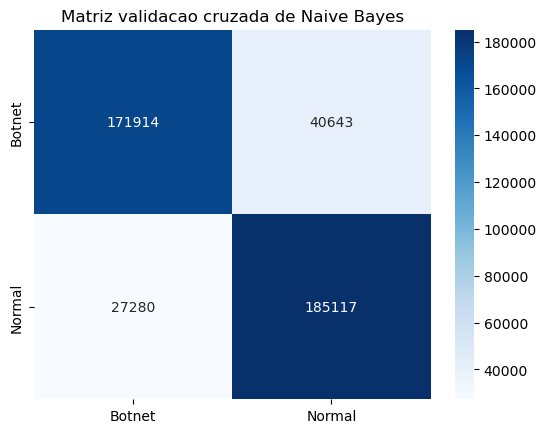

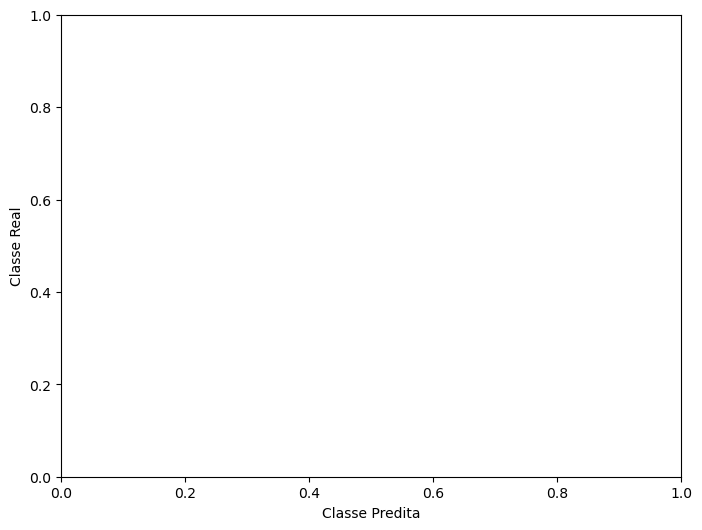

In [40]:
#visualizar_matriz(matrz_nb,"Matriz validacao cruzada de Naive")
visualizar_matriz(matrz_nb,"Matriz validacao cruzada de Naive Bayes")


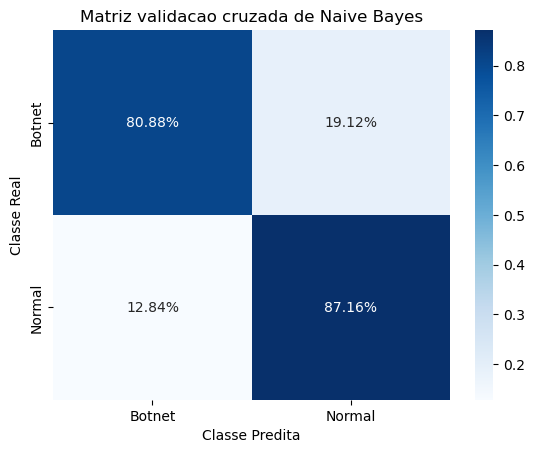

In [41]:
visualizar_matriz_percentagem(matrz_nb_percentagem,"Matriz validacao cruzada de Naive Bayes")

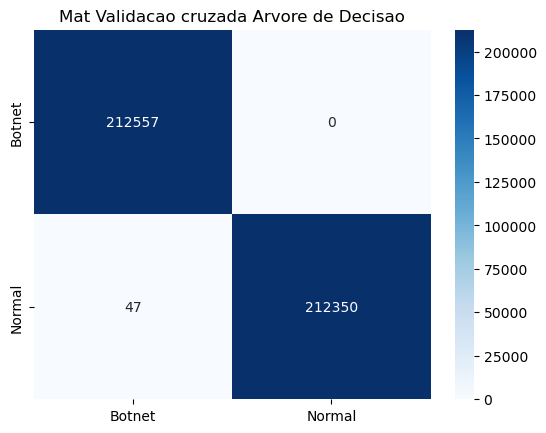

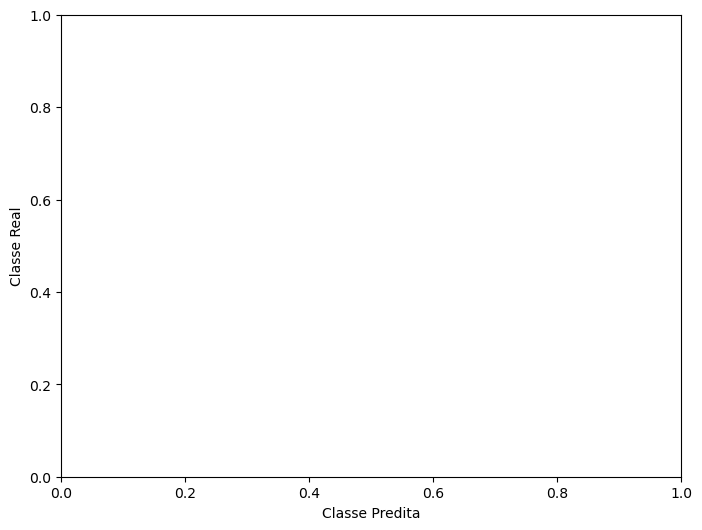

In [42]:
visualizar_matriz(matrz_dt,"Mat Validacao cruzada Arvore de Decisao")


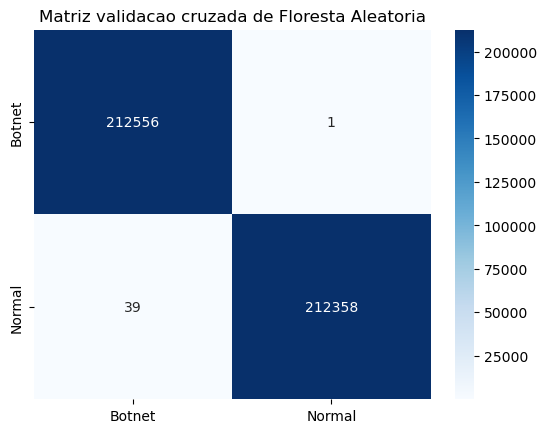

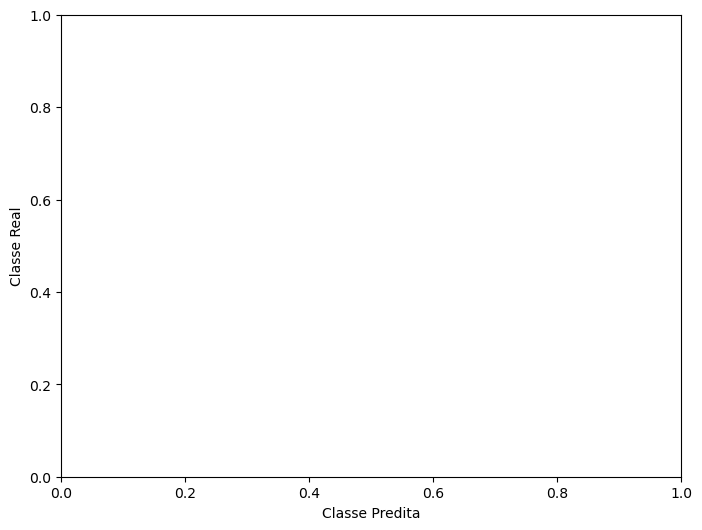

In [43]:
visualizar_matriz(matrz_rfc,"Matriz validacao cruzada de Floresta Aleatoria")


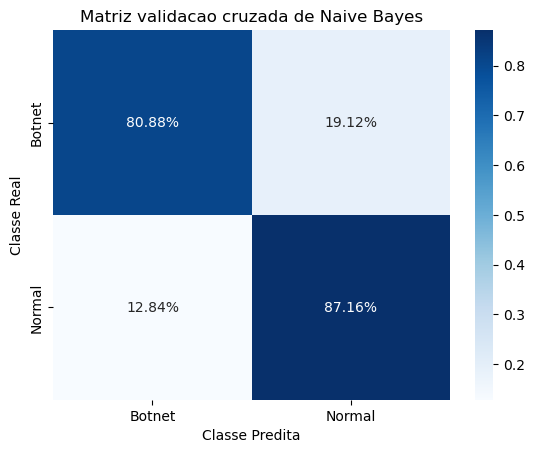

In [45]:

visualizar_matriz_percentagem(matrz_nb_percentagem,"Matriz validacao cruzada de Naive Bayes")


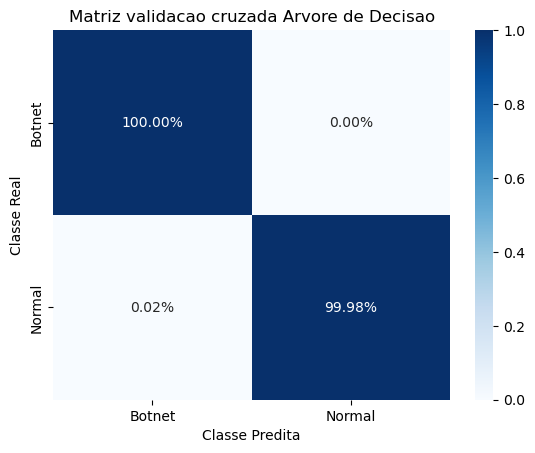

In [46]:
visualizar_matriz_percentagem(matrz_dt_percentagem,"Matriz validacao cruzada Arvore de Decisao")


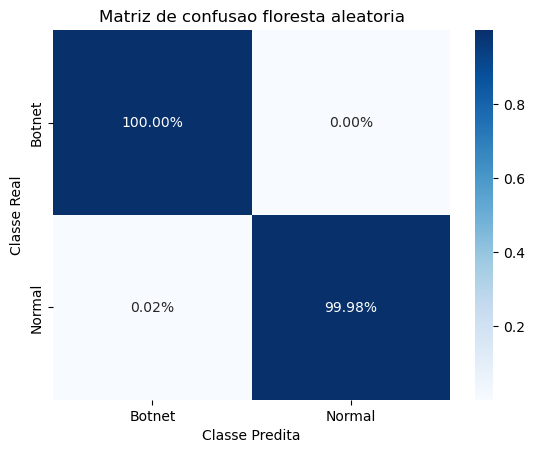

In [47]:
visualizar_matriz_percentagem(matrz_rfc_percentagem, "Matriz de confusao floresta aleatoria")
